## Fourier ptychographic microscopy image stack reconstruction using implicit neural representations

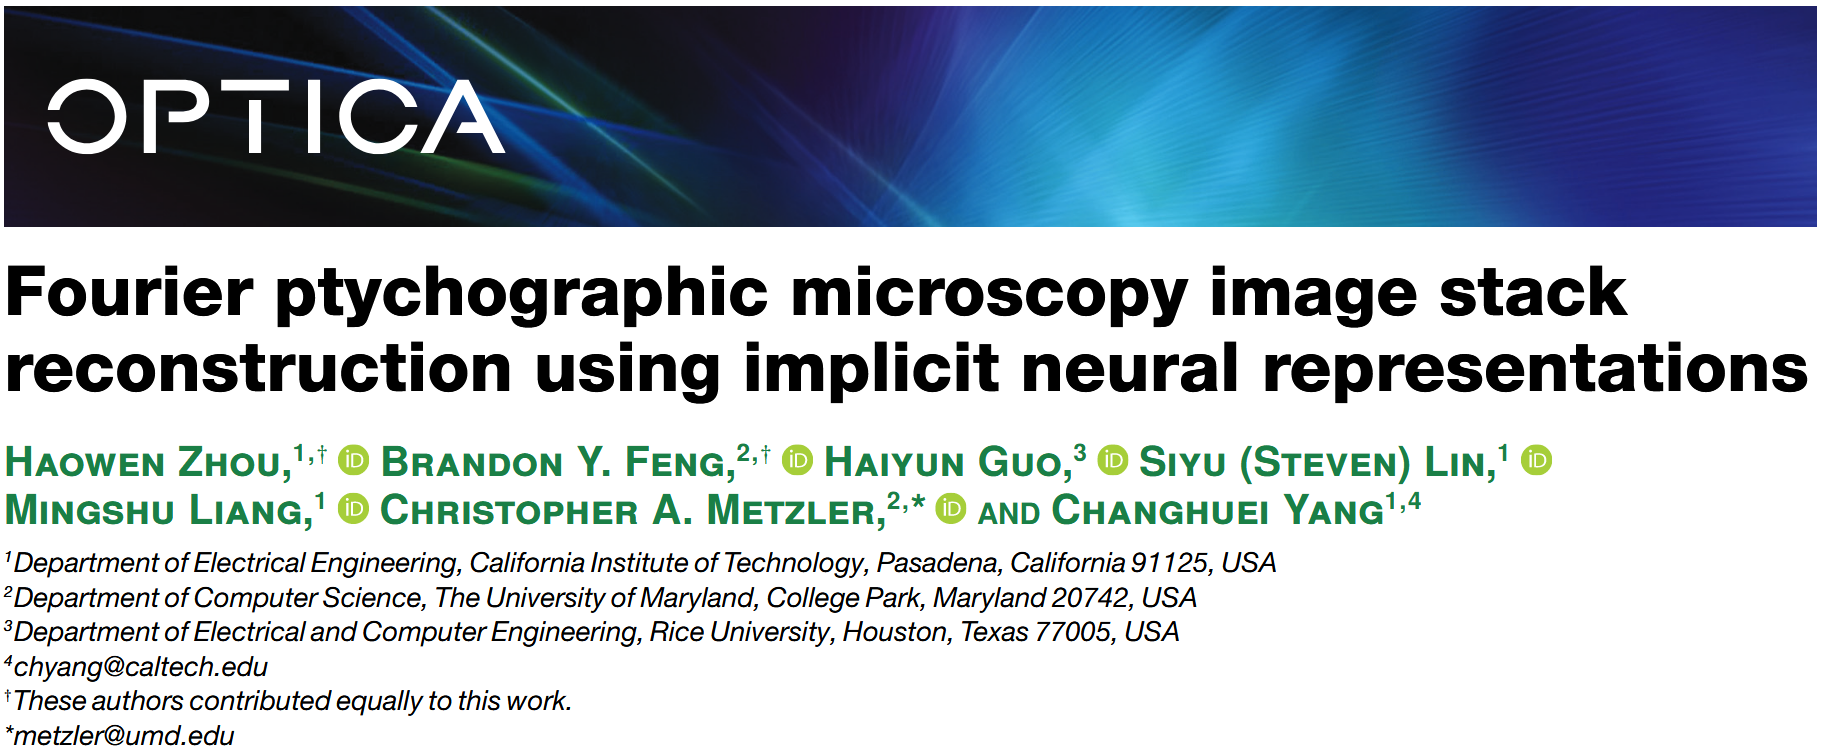

Github Repo: https://github.com/hwzhou2020/FPM_INR, 
Corresponding code: ../../../../code/NeRF_optics/FPM_INR-main/FPM_INR.py
## 1. Highlights

To save memory in Fourier Ptychographic Microscopy (FPM), the authors use Implicit Neural Representations (INRs) to model the 3D complex field, rather than explicitly storing each z-slice.  
Given an input z-value, FPM-INR can efficiently compute the complex field at that depth.  
The entire pipeline is self-supervised and requires no ground-truth labels.  
It combines physics-based optical modeling with neural field learning for compact and continuous volumetric reconstruction.


## 2. Background
### 2.1 What is Fourier Ptychographic Microscopy (FPM)?

Fourier Ptychographic Microscopy (FPM) is a computational imaging technique that enables wide field-of-view (FOV), high-resolution microscopy using simple optics. It works by capturing **multiple low-resolution images under varying illumination angles** and stitching them together in the Fourier domain [Zheng et al., 2013].

Unlike traditional microscopes that rely on physical lens scanning to get different focus planes, FPM uses a computational model to digitally refocus, correct aberrations, and retrieve both amplitude and phase of the optical field — all without moving parts.


### 2.2 What is the "Fourier Stack" in FPM?

In its classic form, FPM reconstructs a **single complex image** (amplitude + phase) at the focal plane — a process often called the “Fourier stack” or “1-layer FPM”. Each angular illumination provides a shifted slice in Fourier space; by combining them, we recover high-frequency content beyond the native resolution of the objective lens.

However, real-world samples have depth. So how do we reconstruct not just one, but a **z-stack** — a full 3D volume?


### 2.3 Why 3D FPM is Hard

To get 3D volumes, traditional FPM methods reconstruct each z-slice separately. But this brings two big problems:

- **Too slow**: each slice is optimized independently, leading to long reconstruction times.
- **Too big**: storing high-res stacks costs gigabytes per sample — not scalable for digital pathology.

### 2.4 FPM-INR: Continuous 3D Reconstruction with Neural Fields

To solve these problems, Zhou et al. (2023) propose **FPM-INR**, a method that combines physics-based optics with **Implicit Neural Representations (INRs)**.

Here’s the key idea:
- Instead of saving every z-slice, use a neural network (MLP) to **learn a compact function** that maps any 3D coordinate (x, y, z) to image intensity and phase.
- This network learns directly from raw measurements using the FPM physical forward model — no pretraining, no black-box hallucinations.

### Why It Matters

FPM-INR:
- Compresses data up to **80×**,
- Speeds up reconstruction by **up to 25×**,
- Supports **continuous** digital refocusing,
- Keeps the physics grounded — no fake details.

This makes real-time, large-scale, and remote FPM imaging practical — opening new doors in biomedical imaging and digital pathology.


## 3. The Core Idea

The Core Idea behind **FPM-INR** is to parameterize a 3D image stack using a small neural network and a low-rank feature volume, then optimize both by fitting a physical forward model that simulates how FPM images are generated.

### 3.1 Forward Model

FPM-INR incorporates the physics of the imaging system in its optimization. The forward model is given by:

$$
I_i(x, y; z) = \left| \mathcal{F}^{-1} \left\{ O(k_x - k_{x_i}, k_y - k_{y_i}) \cdot P(k_x, k_y; z) \right\} \right|^2
$$

Where:
- $I_i(x, y; z)$ is the intensity image from the $i$-th LED,
- $O(k_x, k_y)$ is the object’s Fourier spectrum,
- $P(k_x, k_y; z)$ is the pupil function with defocus phase,
- $\mathcal{F}^{-1}$ denotes inverse Fourier transform.

### 3.2 Pipeline
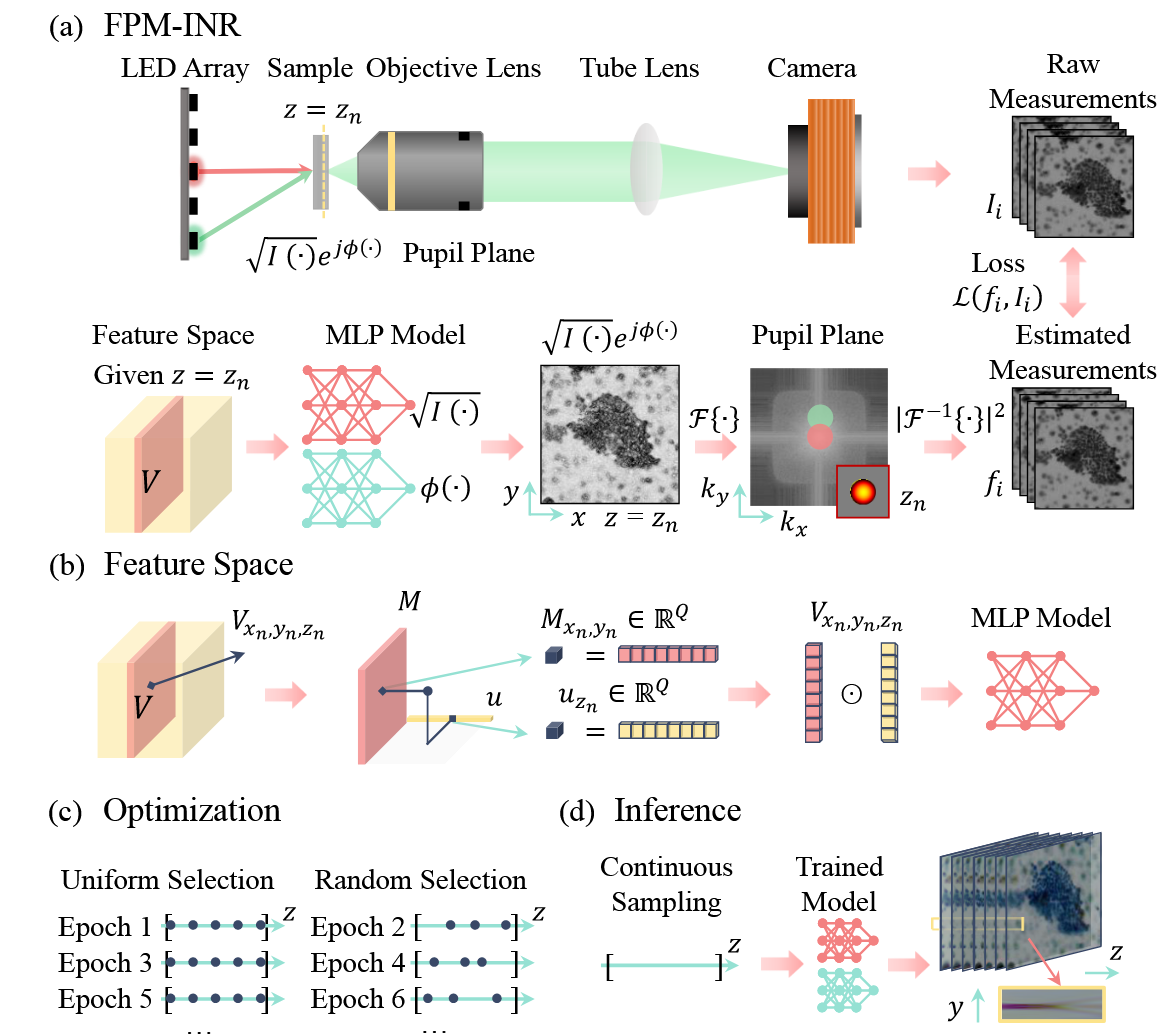
**Input**: A stack of raw intensity images captured under varying LED illumination angles. No physical z-stack scanning or ground-truth depth labels are required.

**Output**: A continuous function that maps any 3D coordinate $(x, y, z)$ to a complex optical field (amplitude and phase), enabling digital refocusing and volumetric reconstruction at arbitrary depths.

**Representation**: The 3D volume is modeled as an implicit function using an MLP, driven by a compact feature space:  
- A 2D feature map $ M(x, y) $  
- A 1D z-vector $ u(z) $  
- Combined via Hadamard product: $ V_{x,y,z} = M_{x,y} \odot u_z $

**Supervision**: Self-supervised training through a physics-based FPM forward model. The predicted optical field is passed through Fourier optics to simulate intensity measurements, which are compared against real camera captures.

**Key Benefit**: Once trained, FPM-INR allows **continuous inference** of any z-plane without retraining, offering efficient and compact 3D imaging without scanning.


## References

1. Zheng, G., Horstmeyer, R., & Yang, C. (2013). *Wide-field, high-resolution Fourier ptychographic microscopy*. Nat. Photonics, 7, 739–745. https://doi.org/10.1038/nphoton.2013.187  
2. Bouchama, L., Dorizzi, B., et al. (2023). *Fourier ptychographic microscopy image enhancement with bi-modal deep learning*. Biomed. Opt. Express, 14, 3172–3189.  
3. Zhou, H., Feng, B. Y., et al. (2023). *Fourier ptychographic microscopy image stack reconstruction using implicit neural representations*. Optica, 10(12), 1679–1687. https://doi.org/10.1364/OPTICA.505283  



In [ ]:
import os
import sys
print("Current working directory:", os.getcwd())
target_path = os.path.abspath(os.path.join(os.getcwd(), "../../../code/NeRF_optics/FPM_INR-main"))
print("Appending path:", target_path)
sys.path.insert(0, target_path)

import tqdm
import mat73
import scipy.io as sio
import imageio
import argparse
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

from network import FullModel
from utils import save_model_with_required_grad

torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

parser = argparse.ArgumentParser([])
parser.add_argument("--num_epochs", default=15, type=int) 
parser.add_argument("--lr_decay_step", default=6, type=int) 
parser.add_argument("--num_feats", default=32, type=int)
parser.add_argument("--num_modes", default=512, type=int)
parser.add_argument("--c2f", default=False, action="store_true")
parser.add_argument("--fit_3D", default=False, action="store_true")
parser.add_argument("--layer_norm", default=False, action="store_true")
parser.add_argument("--amp", default=True, action="store_true")
parser.add_argument("--sample", default="Siemens", type=str)
parser.add_argument("--color", default="r", type=str)
parser.add_argument("--is_system", default="Linux", type=str) # "Windows". "Linux"

args = parser.parse_args([])

fit_3D = args.fit_3D
num_epochs = args.num_epochs
num_feats = args.num_feats
num_modes = args.num_modes
lr_decay_step = args.lr_decay_step
use_c2f = args.c2f
use_layernorm = args.layer_norm
use_amp = args.amp

sample = args.sample
color = args.color
is_os = args.is_system

sample_list = ["BloodSmearTilt", "sheepblood", "WU1005", "Siemens"]
color_list = ['r', 'g', 'b']
if sample not in sample_list: 
    print("Error message: sample name is wrong.")
    print("Avaliable sample names: ['BloodSmearTilt', 'sheepblood', 'WU1005', 'Siemens'] ")
if color not in color_list:
    print("Error message: color name is wrong.")
    print("Avaliable color names: ['r', 'g', 'b']")

vis_dir = f"./vis/feat{num_feats}"


if fit_3D:
    vis_dir += "_3D"
    os.makedirs(f"{vis_dir}/vid", exist_ok=True)
os.makedirs(vis_dir, exist_ok=True)

# Get Sub Spectrum

This function simulates FPM measurements under different LED illuminations.

It takes a complex image, computes its Fourier transform, pads it, extracts sub-spectra for **each LED** based on given coordinates, applies a spectral mask, and returns the corresponding low-resolution intensity images after inverse FFT.

In [ ]:
def get_sub_spectrum(img_complex, led_num, x_0, y_0, x_1, y_1, spectrum_mask, mag):
    O = torch.fft.fftshift(torch.fft.fft2(img_complex))
    to_pad_x = (spectrum_mask.shape[-2] * mag - O.shape[-2]) // 2
    to_pad_y = (spectrum_mask.shape[-1] * mag - O.shape[-1]) // 2
    O = F.pad(O, (to_pad_x, to_pad_x, to_pad_y, to_pad_y, 0, 0), "constant", 0)

    O_sub = torch.stack(
        [O[:, x_0[i] : x_1[i], y_0[i] : y_1[i]] for i in range(len(led_num))], dim=1
    )
    O_sub = O_sub * spectrum_mask
    o_sub = torch.fft.ifft2(torch.fft.ifftshift(O_sub))
    oI_sub = torch.abs(o_sub)

    return oI_sub

# Load data

In [ ]:
if fit_3D:
    data_struct = mat73.loadmat(f"../../../../Datasets/FPM-INR/{sample}/{sample}_{color}.mat")

    I = data_struct["I_low"].astype("float32")

    # Select ROI
    I = I[0:int(num_modes*2), 0:int(num_modes*2), :] 

    # Raw measurement sidelength
    M = I.shape[0]
    N = I.shape[1]
    ID_len = I.shape[2]

    # NAx NAy
    NAs = data_struct["na_calib"].astype("float32")
    NAx = NAs[:, 0]
    NAy = NAs[:, 1]

    # LED central wavelength
    if color == "r":
        wavelength = 0.632  # um
    elif color == "g":
        wavelength = 0.5126  # um
    elif color == "b":
        wavelength = 0.471  # um

    # Distance between two adjacent LEDs (unit: um)
    D_led = 4000
    # free-space k-vector
    k0 = 2 * np.pi / wavelength
    # Objective lens magnification
    mag = data_struct["mag"].astype("float32")
    # Camera pixel pitch (unit: um)
    pixel_size = data_struct["dpix_c"].astype("float32")
    # pixel size at image plane (unit: um)
    D_pixel = pixel_size / mag
    # Objective lens NA
    NA = data_struct["na_cal"].astype("float32")
    # Maximum k-value
    kmax = NA * k0

    # Calculate upsampliing ratio
    MAGimg = 2
    # Upsampled pixel count
    MM = int(M * MAGimg)
    NN = int(N * MAGimg)

    # Define spatial frequency coordinates
    Fxx1, Fyy1 = np.meshgrid(np.arange(-NN / 2, NN / 2), np.arange(-MM / 2, MM / 2))
    Fxx1 = Fxx1[0, :] / (N * D_pixel) * (2 * np.pi)
    Fyy1 = Fyy1[:, 0] / (M * D_pixel) * (2 * np.pi)

    # Calculate illumination NA
    u = -NAx
    v = -NAy
    NAillu = np.sqrt(u**2 + v**2)
    order = np.argsort(NAillu)
    u = u[order]
    v = v[order]

    # NA shift in pixel from different LED illuminations
    ledpos_true = np.zeros((ID_len, 2), dtype=int)
    count = 0
    for idx in range(ID_len):
        Fx1_temp = np.abs(Fxx1 - k0 * u[idx])
        ledpos_true[count, 0] = np.argmin(Fx1_temp)
        Fy1_temp = np.abs(Fyy1 - k0 * v[idx])
        ledpos_true[count, 1] = np.argmin(Fy1_temp)
        count += 1
    # Raw measurements
    Isum = I[:, :, order] / np.max(I)

else:
    if sample == 'Siemens':
        data_struct = sio.loadmat(f"../../../../Datasets/FPM-INR/{sample}/{sample}_{color}.mat")
        MAGimg = 3

    else:
        data_struct = mat73.loadmat(f"../../../../Datasets/FPM-INR/{sample}/{sample}_{color}.mat")
        MAGimg = 2

        
    I = data_struct["I_low"].astype("float32")

    # Select ROI
    I = I[0:int(num_modes), 0:int(num_modes), :] #######################

    # Raw measurement sidelength
    M = I.shape[0]
    N = I.shape[1]
    ID_len = I.shape[2]

    # NAx NAy
    NAs = data_struct["na_calib"].astype("float32")
    NAx = NAs[:, 0]
    NAy = NAs[:, 1]

    # LED central wavelength
    if color == "r":
        wavelength = 0.632  # um
    elif color == "g":
        wavelength = 0.5126  # um
    elif color == "b":
        wavelength = 0.471  # um

    # Distance between two adjacent LEDs (unit: um)
    D_led = 4000
    # free-space k-vector
    k0 = 2 * np.pi / wavelength
    # Objective lens magnification
    mag = data_struct["mag"].astype("float32")
    # Camera pixel pitch (unit: um)
    pixel_size = data_struct["dpix_c"].astype("float32")
    # pixel size at image plane (unit: um)
    D_pixel = pixel_size / mag
    # Objective lens NA
    NA = data_struct["na_cal"].astype("float32")
    # Maximum k-value
    kmax = NA * k0

    # Calculate upsampliing ratio
    # MAGimg = 2
    # Upsampled pixel count
    MM = int(M * MAGimg)
    NN = int(N * MAGimg)

    # Define spatial frequency coordinates
    Fxx1, Fyy1 = np.meshgrid(np.arange(-NN / 2, NN / 2), np.arange(-MM / 2, MM / 2))
    Fxx1 = Fxx1[0, :] / (N * D_pixel) * (2 * np.pi)
    Fyy1 = Fyy1[:, 0] / (M * D_pixel) * (2 * np.pi)

    # Calculate illumination NA
    u = -NAx
    v = -NAy
    NAillu = np.sqrt(u**2 + v**2)
    order = np.argsort(NAillu)
    u = u[order]
    v = v[order]

    # NA shift in pixel from different LED illuminations
    ledpos_true = np.zeros((ID_len, 2), dtype=int)
    count = 0
    for idx in range(ID_len):
        Fx1_temp = np.abs(Fxx1 - k0 * u[idx])
        ledpos_true[count, 0] = np.argmin(Fx1_temp)
        Fy1_temp = np.abs(Fyy1 - k0 * v[idx])
        ledpos_true[count, 1] = np.argmin(Fy1_temp)
        count += 1
    # Raw measurements
    Isum = I[:, :, order] / np.max(I)

# Define Angular Spectrum
This section prepares some variables for the forward model. It is based on the physical principle described in the paper (Eq. 1):

$$
I_i(x, y; z) = \left| \mathcal{F}^{-1} \left\{ O(k_x - k_{x_i}, k_y - k_{y_i}) \cdot P(k_x, k_y; z) \right\} \right|^2
$$

- $O(k_x, k_y)$: Fourier transform of the complex sample at depth $z$
- $P(k_x, k_y; z)$: pupil function with defocus phase
- $I_i(x, y; z)$: simulated intensity for LED $i$

The corresponding components in code are:

```python
# Build Fourier grid
kxx, kyy = np.meshgrid(...)        # k_x, k_y
krr = np.sqrt(kxx**2 + kyy**2)     # frequency radius
k0 = 2 * np.pi / wavelength
kzz = np.sqrt(k0**2 - krr**2)      # z-direction propagation term

# Binary pupil mask (NA-limited aperture)
Pupil0 = (Fxy**2 <= kmax**2)       # support of P(kx, ky)
```
#### Full forward model (in `FullModel`)
```python
complex_field = amplitude * torch.exp(1j * phase)
O_k = torch.fft.fft2(complex_field)
shifted = spectrum_shift(O_k, kx_i, ky_i)
pupil = Pupil0 * torch.exp(1j * kzz * z)
estimated = torch.abs(torch.fft.ifft2(shifted * pupil)) ** 2

In [ ]:
if sample == 'Siemens':
    kxx, kyy = np.meshgrid(Fxx1[0,:M], Fxx1[0,:N])   
else:
    kxx, kyy = np.meshgrid(Fxx1[:M], Fxx1[:N])
kxx, kyy = kxx - np.mean(kxx), kyy - np.mean(kyy)
krr = np.sqrt(kxx**2 + kyy**2)
mask_k = k0**2 - krr**2 > 0
kzz_ampli = mask_k * np.abs(
    np.sqrt((k0**2 - krr.astype("complex64") ** 2))
)  
kzz_phase = np.angle(np.sqrt((k0**2 - krr.astype("complex64") ** 2)))
kzz = kzz_ampli * np.exp(1j * kzz_phase)

# Define Pupil support
Fx1, Fy1 = np.meshgrid(np.arange(-N / 2, N / 2), np.arange(-M / 2, M / 2))
Fx2 = (Fx1 / (N * D_pixel) * (2 * np.pi)) ** 2
Fy2 = (Fy1 / (M * D_pixel) * (2 * np.pi)) ** 2
Fxy2 = Fx2 + Fy2
Pupil0 = np.zeros((M, N))
Pupil0[Fxy2 <= (kmax**2)] = 1

Pupil0 = (
    torch.from_numpy(Pupil0).view(1, 1, Pupil0.shape[0], Pupil0.shape[1]).to(device)
)
kzz = torch.from_numpy(kzz).to(device).unsqueeze(0)
Isum = torch.from_numpy(Isum).to(device)

if fit_3D:
    # Define depth of field of brightfield microscope for determine selected z-plane
    DOF = (
        0.5 / NA**2 #+ pixel_size / mag / NA
    )  # wavelength is emphrically set as 0.5 um
    # z-slice separation (emphirically set)
    delta_z = 0.8 * DOF
    # z-range
    z_max = 20.0
    z_min = -20.0
    # number of selected z-slices
    num_z = int(np.ceil((z_max - z_min) / delta_z))
    
    # print(num_z)
else:
    z_min = 0.0
    z_max = 1.0

# Define LED Batch size

In [ ]:
led_batch_size = 1
cur_ds = 1
if use_c2f:
    c2f_sche = (
        [4] * (num_epochs // 5)
        + [2] * (num_epochs // 5)
        + [1] * (num_epochs // 5)
    )
    cur_ds = c2f_sche[0]

model = FullModel(
    w=MM,
    h=MM,
    num_feats=num_feats,
    x_mode=num_modes,
    y_mode=num_modes,
    z_min=z_min,
    z_max=z_max,
    ds_factor=cur_ds,
    use_layernorm=use_layernorm,
).to(device)

optimizer = torch.optim.Adam(
    lr=1e-3,
    params=filter(lambda p: p.requires_grad, model.parameters()),
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=lr_decay_step, gamma=0.1
)

t = tqdm.trange(num_epochs)

# Training Loop

In [ ]:
for epoch in t:
    led_idices = list(np.arange(ID_len))  # list(np.random.permutation(ID_len)) #
    # _fill = len(led_idices) - (len(led_idices) % led_batch_size)
    # led_idices = led_idices + list(np.random.choice(led_idices, _fill, replace=False))
    if fit_3D:
        dzs = (
            (torch.randperm(num_z - 1)[: num_z // 2] + torch.rand(num_z // 2))
            * ((z_max - z_min) // (num_z - 1))
        ).to(device) + z_min
        if epoch % 2 == 0:
            dzs = torch.linspace(z_min, z_max, num_z).to(device)
    else:
        dzs = torch.FloatTensor([0.0]).to(device)

    if use_c2f and c2f_sche[epoch] < model.ds_factor:
        model.init_scale_grids(ds_factor=c2f_sche[epoch])
        print(f"ds_factor changed to {c2f_sche[epoch]}")
        model_fn = torch.jit.trace(model, dzs[0:1])

    if epoch == 0:
        if is_os == "Windows":
            model_fn = torch.jit.trace(model, dzs[0:1])
        elif is_os == "Linux":
            model_fn = torch.compile(model, backend="inductor")
        else:
            raise NotImplementedError


    for dz in dzs:
        dz = dz.unsqueeze(0)

        for it in range(ID_len // led_batch_size):  # + 1
            model.zero_grad()
            dfmask = torch.exp(
                1j
                * kzz.repeat(dz.shape[0], 1, 1)
                * dz[:, None, None].repeat(1, kzz.shape[1], kzz.shape[2])
            )
            led_num = led_idices[it * led_batch_size : (it + 1) * led_batch_size]
            dfmask = dfmask.unsqueeze(1).repeat(1, len(led_num), 1, 1)
            spectrum_mask_ampli = Pupil0.repeat(
                len(dz), len(led_num), 1, 1
            ) * torch.abs(dfmask)
            spectrum_mask_phase = Pupil0.repeat(len(dz), len(led_num), 1, 1) * (
                torch.angle(dfmask) + 0
            )  # 0 represent Pupil0 Phase
            spectrum_mask = spectrum_mask_ampli * torch.exp(
                1j * spectrum_mask_phase
            )

            with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.bfloat16):
                img_ampli, img_phase = model_fn(dz)
                img_complex = img_ampli * torch.exp(1j * img_phase)
                uo, vo = ledpos_true[led_num, 0], ledpos_true[led_num, 1]
                x_0, x_1 = vo - M // 2, vo + M // 2
                y_0, y_1 = uo - N // 2, uo + N // 2

                oI_cap = torch.sqrt(Isum[:, :, led_num])
                oI_cap = (
                    oI_cap.permute(2, 0, 1).unsqueeze(0).repeat(len(dz), 1, 1, 1)
                )

                oI_sub = get_sub_spectrum(
                    img_complex, led_num, x_0, y_0, x_1, y_1, spectrum_mask, MAGimg
                )

                l1_loss = F.smooth_l1_loss(oI_cap, oI_sub)
                loss = l1_loss
                mse_loss = F.mse_loss(oI_cap, oI_sub)

            loss.backward()

            psnr = 10 * -torch.log10(mse_loss).item()
            t.set_postfix(Loss=f"{loss.item():.4e}", PSNR=f"{psnr:.2f}")
            optimizer.step()

    scheduler.step()
    

    if (epoch+1) % 10 == 0 or ( epoch % 2 == 0 and epoch < 20) or epoch == num_epochs:

        amplitude = (img_ampli[0].float()).cpu().detach().numpy() 
        phase = (img_phase[0].float()).cpu().detach().numpy()

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

        im = axs[0].imshow(amplitude, cmap="gray")
        axs[0].axis("image")
        axs[0].set_title("Reconstructed amplitude")
        divider = make_axes_locatable(axs[0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        im = axs[1].imshow(phase , cmap="gray") # - phase.mean()
        axs[1].axis("image")
        axs[1].set_title("Reconstructed phase")
        divider = make_axes_locatable(axs[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        plt.savefig(f"{vis_dir}/e_{epoch}.png")
        plt.show()


    if fit_3D and (epoch % 5 == 0 or epoch == num_epochs) and epoch > 0:
        dz = torch.linspace(z_min, z_max, 61).to(device).view(61)
        with torch.no_grad():
            out = []
            for z in torch.chunk(dz, 32):
                img_ampli, img_phase = model(z)
                _img_complex = img_ampli * torch.exp(1j * img_phase)
                out.append(_img_complex)
            img_complex = torch.cat(out, dim=0)
        _imgs = img_complex.abs().cpu().detach().numpy()
        # Save amplitude
        imgs = (_imgs - _imgs.min()) / (_imgs.max() - _imgs.min())
        imageio.mimsave(
            f"{vis_dir}/vid/{epoch}.mp4", np.uint8(imgs * 255), fps=5, quality=8
        )
save_path = os.path.join(f'../../../../code/NeRF_optics/FPM_INR-main/trained_models/{sample}', sample +'_'+ color + '.pth')
save_model_with_required_grad(model, save_path)